Import libraries

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding,Dropout,TimeDistributed,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import numpy as np

%matplotlib inline

Read and plot our dataset

In [95]:
df = pd.read_csv('./regression_data/time_series.csv',delimiter='\t')
df.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,-0.979234,-1.416973,-0.489459,-1.729622,-0.134724,-1.807650,-1.457204,-1.519507,-0.941327,-1.557292,...,-1.125021,-0.911043,-1.699759,-1.440899,-1.283851,0.685304,0.713689,0.752802,0.978494,1.572911
1,-1.299158,-1.113212,-0.632251,-1.737313,-0.248217,-1.564086,-0.950444,-1.346987,-0.197287,-1.161736,...,-1.262253,-1.376927,-1.407816,-1.396224,-0.930486,0.320177,0.639225,-0.313674,0.210078,0.551663
2,-1.376446,-1.950953,-1.086232,-0.829957,-0.726847,-1.219189,-0.941770,-1.080390,0.040752,-1.040056,...,-0.885993,-1.338449,-1.050405,-1.708525,-1.204798,0.299045,0.544369,-0.627268,0.679768,0.695625
3,-1.411108,-2.811393,-1.302569,-1.132002,0.212635,-0.227358,-0.023937,-0.237467,-0.007999,-0.249670,...,-0.125433,-0.288851,-1.181771,-0.844498,0.190256,0.358886,-0.151826,0.760449,1.694166,0.168652
4,-1.609624,-2.773193,-0.696774,-1.382566,-0.250348,0.794368,0.499432,0.234127,0.178348,0.649898,...,0.548304,0.925362,-0.307231,0.389952,0.830964,0.279175,0.113457,0.253286,1.236159,-0.408116


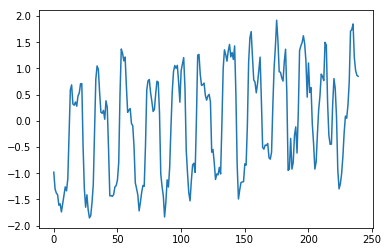

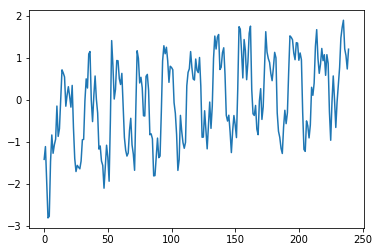

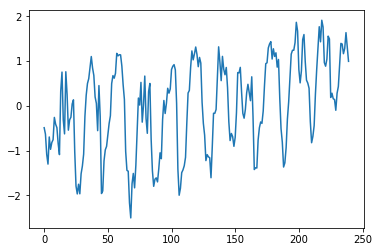

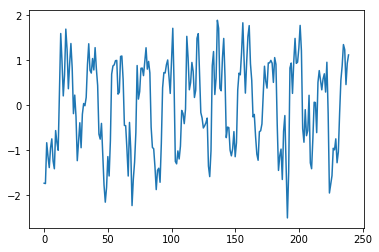

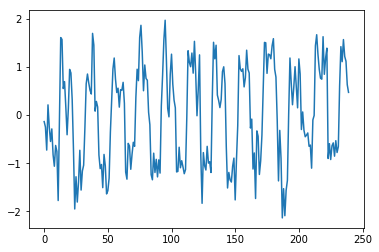

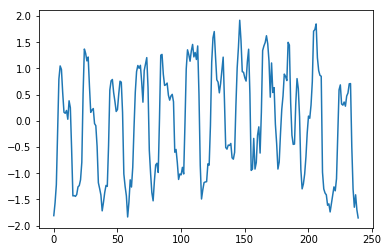

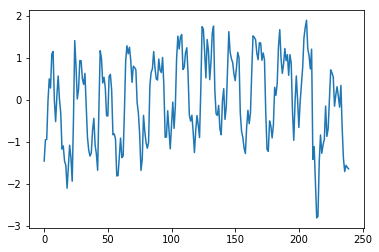

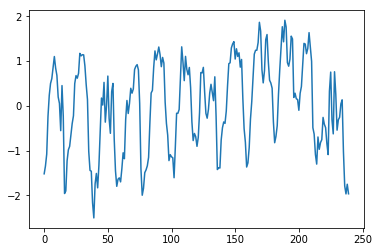

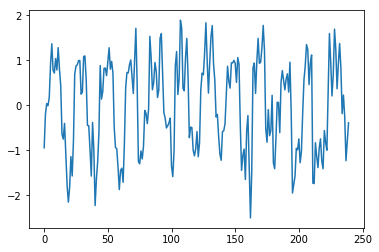

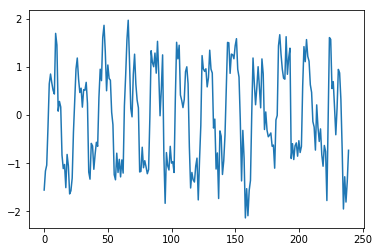

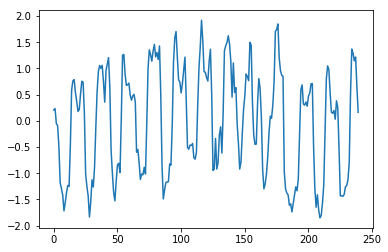

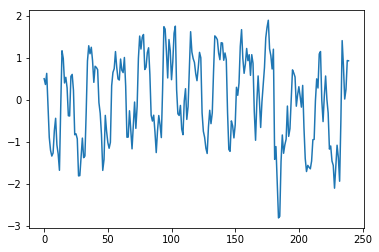

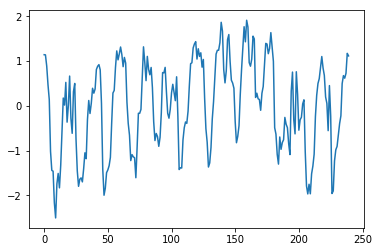

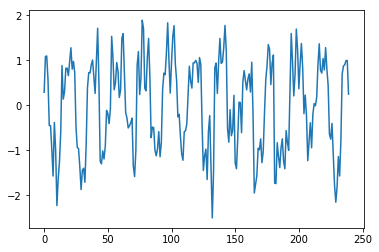

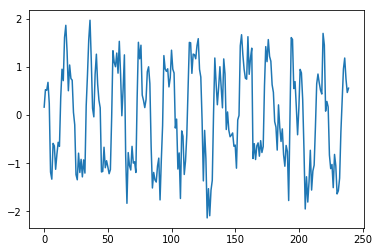

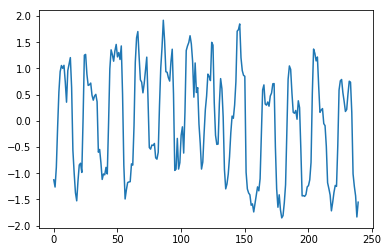

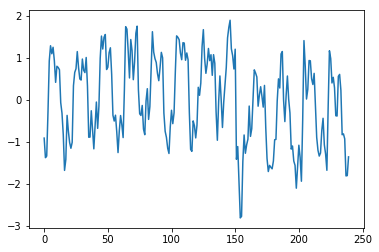

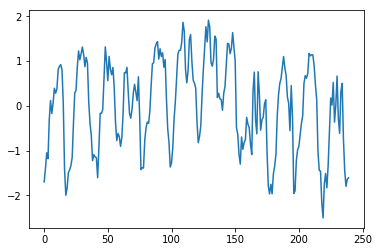

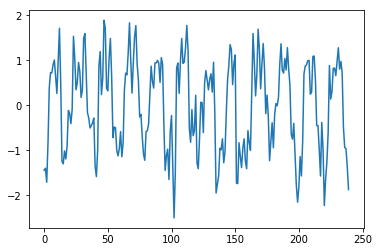

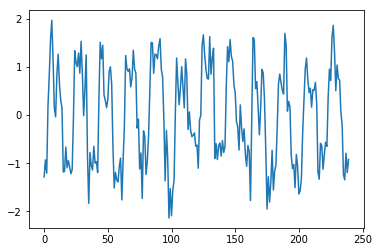

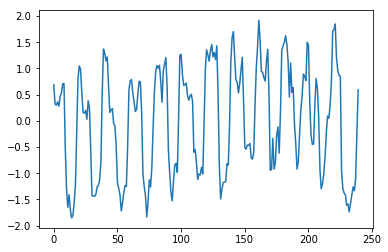

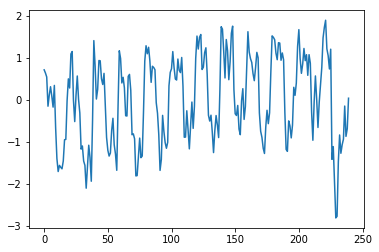

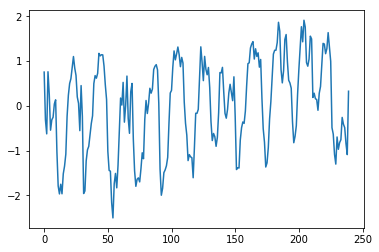

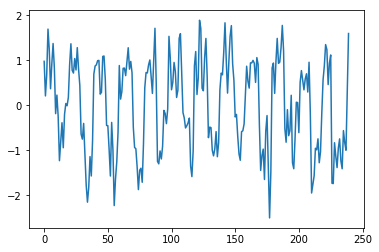

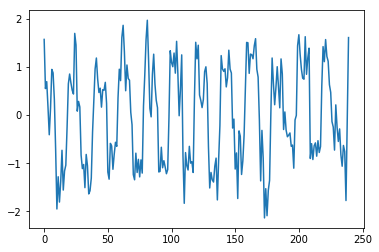

In [96]:
for i in df.columns:
    df[i].plot()
    plt.show()

As we can see, all the data are very similar, so we can create one model and fit it on the all the time series, using 20% of them as a test data.

Scale our data.

In [97]:
mms = MinMaxScaler(feature_range=(-1, 1))
data = mms.fit_transform(df)

Implement a function that create features and target value from our time series with defined lag

In [98]:
def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
        
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[:-1, :]
    
    if not as_array:
        return X, y
    else:
        return X.values, y.values

Create train and test dataset from our data using the function. In our case 'lag' is a hyperparameter.

In [99]:
lag = 20

train_X = np.array([]).reshape(0,lag)
train_y = np.array([])

test_X = np.array([]).reshape(0,lag)
test_y = np.array([])

one_line_data = np.array([])

test_size = round(data.shape[1]/5)

for i in range(data.shape[1]-test_size):
    X, y = create_data(data[:,i],lag)
    train_X = np.concatenate((train_X,X),axis=0)
    train_y = np.concatenate((train_y,y),axis=0)
    one_line_data = np.concatenate((one_line_data,data[:,i]),axis=0)
    
for i in range(data.shape[1]-test_size,data.shape[1]):  
    X, y = create_data(data[:,i],lag)
    test_X = np.concatenate((test_X,X),axis=0)
    test_y = np.concatenate((test_y,y),axis=0)
    one_line_data = np.concatenate((one_line_data,data[:,i]),axis=0)
    
one_line_data = one_line_data.reshape(-1,1)

Reshape input to be [samples, time steps, features]

In [100]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
print(test_X.shape)
print(test_y.shape)

(1100, 20, 1)
(1100,)


Create a neural network with different numbers of LSTM layers, trying different parameters.

In [104]:
np.random.seed(42)

batch_size = 1
model = Sequential()
# model.add(LSTM(2, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True, return_sequences=True))
model.add(LSTM(4, 
               batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), 
               stateful=True))
# model.add(Dense(4,activation='relu'))
model.add(Dense(1))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (1, 4)                    96        
_________________________________________________________________
dense_14 (Dense)             (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Compile and fit our neural network.

In [105]:
model.compile(loss='mean_squared_error', optimizer='adam')
number_of_steps = 30
for i in range(number_of_steps):
    print('Step '+str(i+1)+'/'+str(number_of_steps))
    model.fit(train_X, train_y, validation_data=(test_X, test_y), 
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Step 1/30
Train on 4400 samples, validate on 1100 samples
Epoch 1/1
4400/4400 [==============================] - 35s 8ms/step - loss: 0.0868 - val_loss: 0.0737
Step 2/30
Train on 4400 samples, validate on 1100 samples
Epoch 1/1
4400/4400 [==============================] - 29s 7ms/step - loss: 0.0686 - val_loss: 0.0704
Step 3/30
Train on 4400 samples, validate on 1100 samples
Epoch 1/1
4400/4400 [==============================] - 32s 7ms/step - loss: 0.0650 - val_loss: 0.0652
Step 4/30
Train on 4400 samples, validate on 1100 samples
Epoch 1/1
4400/4400 [==============================] - 32s 7ms/step - loss: 0.0568 - val_loss: 0.0548
Step 5/30
Train on 4400 samples, validate on 1100 samples
Epoch 1/1
4400/4400 [==============================] - 33s 7ms/step - loss: 0.0505 - val_loss: 0.0502
Step 6/30
Train on 4400 samples, validate on 1100 samples
Epoch 1/1
4400/4400 [==============================] - 32s 7ms/step - loss: 0.0471 - val_loss: 0.0474
Step 7/30
Train on 4400 samples, validat

Plot the results.

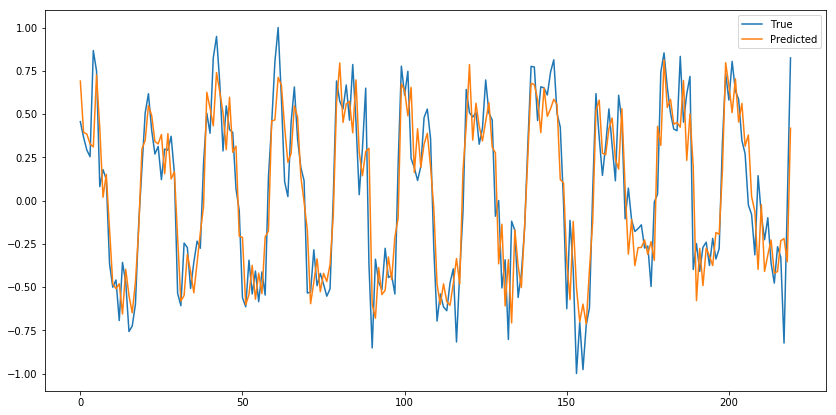

In [110]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

train_predict = model.predict(train_X, batch_size=batch_size)
test_predict = model.predict(test_X, batch_size=batch_size)
test_observed = one_line_data[-len(test_predict):, :]

# print('MAE = ', mean_absolute_error(test_observed, test_predict))
# print('MSE = ', mean_squared_error(test_observed, test_predict))

# shift train predictions for plotting
train_predict_plot = np.empty_like(one_line_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_predict)+lag, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(one_line_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_predict):, :] = test_predict

# shift true values for plotting with test data only
test_true_plot = np.empty_like(one_line_data)
test_true_plot[:, :] = np.nan
test_true_plot[-len(test_predict):, :] = one_line_data[-len(test_predict):,:]
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
# plt.plot(one_line_data)
# plt.plot(train_predict_plot)
plt.plot(test_true_plot[-len(test_predict)//5:,:],label='True')
plt.plot(test_predict_plot[-len(test_predict)//5:,:],label='Predicted')
plt.legend()
plt.show()